# Introduction

First submission :

<a href='#1'>1. Loading Data</a>

<a href='#2'>2. Combining Datasets</a>

<a href='#3'>3. Memory Limitation</a>

<a href='#4'>4. Missing Values</a>

<a href='#5'>5.EDA</a>

<a href='#6'>6. Model Training</a>

<a href='#7'>7. Model Predictions and Kaggle Submission</a>

# <a id='1'>1. Loading Data</a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv')
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv')
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv')

In [3]:
train.shape

(20216100, 4)

In [4]:
test.shape

(41697600, 4)

For a simple first model, we are going to merge the training sets to gather all covariables and make predictions on it with a linear regressor.

# <a id='2'>2. Combining Datasets</a>
We will merge everything into train and test dataframes.

We need to convert the timestamp to the right type:

In [5]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) 
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [6]:
#merge the building meta data and weather data into the train data
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test
import gc
gc.collect() #mandatory since we don't have unlimited space (16go and the databases are quite large)
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


# <a id='3'>3. Memory Limitation</a>

In [7]:
def reduce_mem_usage(df, verbose=True): #we need to drastically reduce memory usage to work with those data basis
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m) #this code changes the variable formats so it takes less space
test_m = reduce_mem_usage(test_m) #source for this code : https://www.kaggle.com/alexandersylvester/ashrae-energy-predictions-with-lightgbm

Mem. usage decreased to 1041.10 Mb (60.3% reduction)
Mem. usage decreased to 2147.36 Mb (60.3% reduction)


# <a id='4'>4. Missing Values</a>

In [ ]:
train_m.isna().describe()

In [ ]:
test_m.isna().describe()

The easy way out in this scenario is to drop the columns containing any NA. Which we're going to do for the time being. We have no missing value for the target variable so we will not be dropping any training row

In [ ]:
train_m = train_m.dropna(axis='columns')

In [ ]:
gc.collect(generation=0)
gc.collect(generation=1)
gc.collect() #supposedly cleans the memory but not that efficient // we need a better way

In [ ]:
test_m = test_m.dropna(axis='columns')

In [ ]:
train_m.describe()

In [ ]:
test_m.describe()

In [ ]:
train_m.groupby("primary_use").sum()

In [ ]:
train_m.primary_use = train_m.primary_use.astype('category')
test_m.primary_use = test_m.primary_use.astype('category')

In [ ]:
# dr = test_m.primary_use
# test_m = test_m.drop('primary_use',axis=1)

In [ ]:
# dr2 = train_m.primary_use
# train_m = train_m.drop('primary_use',axis=1)
## train_m = train_m.drop('meter_reading',axis=1)

In [ ]:
test_m.dtypes

In [ ]:
train_m.dtypes

In [ ]:
train_df = train_m
test_df = test_m

In [ ]:
import math

train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
# train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

# <a id='5'>5. EDA</a>

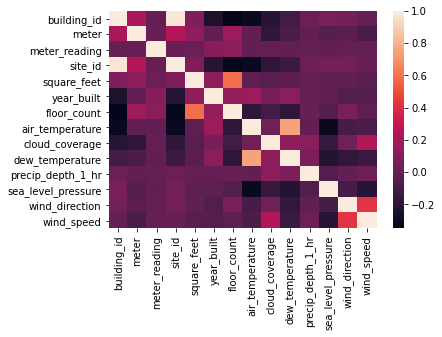

In [10]:
mat_coorr=train_m.corr()
sn.heatmap(mat_coorr)
plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

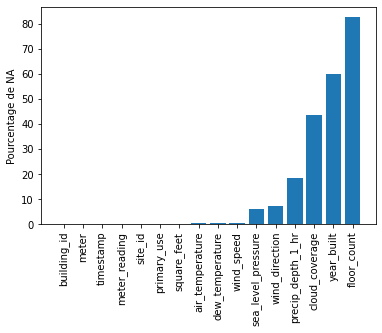

In [31]:
is_na=train_m.isnull().sum()*100/train_m.shape[0]
is_na=is_na.sort_values()
ind = np.arange(len(is_na))
plt.bar(ind, is_na.values)
plt.xticks(ind,is_na.index,rotation=90)
plt.ylabel("Pourcentage de NA")
plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

# <a id='6'>6. Model Training</a>

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV #, train_test_split,TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

y_train = train_m['meter_reading']

# my_tree = DecisionTreeRegressor()

# MSE = make_scorer(mean_squared_error)

In [ ]:
test_m

In [ ]:
# param_grid = {'splitter' : ['best', 'random'],'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson']}
# model = GridSearchCV(my_tree, param_grid, scoring=MSE)

In [ ]:
train_df = train_df.drop('timestamp', axis = 1)

test_df = test_df.drop('timestamp', axis = 1)

In [ ]:
# predicted = model.predict(test_df)

# print('Best Parameters found for MSE : ',model.best_params_)
# print('Train Score : ',model.score(train_m.drop('meter_reading') , y_train))


from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from math import sqrt

X = train_df
X_test = test_df
y = y_train

reg = tree.DecisionTreeRegressor(max_leaf_nodes=50)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression de train",sqrt(mean_squared_error(y, y_train_predict_tree)))

In [ ]:
print("La RMSLE de l'arbre de régression de train",sqrt(mean_squared_log_error(y, y_train_predict_tree)))

Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

In [ ]:
#obtention des prédictions et du fichier à évaluer 
y_test_predict_tree=reg.predict(X_test)

my_submission = pd.DataFrame({'row_id': test_m.row_id, 'meter_reading': y_test_predict_tree})
my_submission.to_csv('submission_tree_f.csv', index=False)